Milestone 3 Group Project

In [ ]:
# Install required packages
!pip install pyspark kaggle --quiet


In [ ]:
import shutil
import os

# Add kaggle CLI to PATH so !kaggle works
os.environ['PATH'] += os.pathsep + os.path.expanduser('~/.local/bin')

# Create the .kaggle directory if it doesn't exist
os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)

# Move kaggle.json into the .kaggle directory
shutil.move('kaggle.json', os.path.expanduser('~/.kaggle/kaggle.json'))

# Set file permissions
os.chmod(os.path.expanduser('~/.kaggle/kaggle.json'), 0o600)


In [ ]:
#initialize spark session
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("AmazonReviewsMerge")\
    .config("spark.driver.memory", "64g") \
    .config("spark.executor.memory", "64g") \
    .config('spark.executor.instances', 7) \
    .getOrCreate()



In [ ]:
#Useful Libraries
from functools import reduce
from pyspark.sql.functions import col, trim, round, row_number, lit, rand, length, avg
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType

In [ ]:
#Define file list
file_list = [
    "amazon_reviews_us_Beauty_v1_00.tsv",
    "amazon_reviews_us_Automotive_v1_00.tsv",
    "amazon_reviews_us_Digital_Music_Purchase_v1_00.tsv",
    "amazon_reviews_us_Outdoors_v1_00.tsv",
    "amazon_reviews_us_Baby_v1_00.tsv",
    "amazon_reviews_us_Electronics_v1_00.tsv",
    "amazon_reviews_us_Gift_Card_v1_00.tsv",
    "amazon_reviews_us_Furniture_v1_00.tsv",
    "amazon_reviews_us_Tools_v1_00.tsv"
]


In [ ]:
#download kaggle files
for file in file_list:
    !kaggle datasets download -d cynthiarempel/amazon-us-customer-reviews-dataset -f {file} --force


Dataset URL: https://www.kaggle.com/datasets/cynthiarempel/amazon-us-customer-reviews-dataset
License(s): other
100%|███████████████████████████████████████▉| 882M/882M [00:25<00:00, 39.3MB/s]
100%|████████████████████████████████████████| 882M/882M [00:25<00:00, 36.5MB/s]
Dataset URL: https://www.kaggle.com/datasets/cynthiarempel/amazon-us-customer-reviews-dataset
License(s): other
100%|███████████████████████████████████████▉| 560M/561M [00:16<00:00, 39.9MB/s]
100%|████████████████████████████████████████| 561M/561M [00:16<00:00, 36.6MB/s]
Dataset URL: https://www.kaggle.com/datasets/cynthiarempel/amazon-us-customer-reviews-dataset
License(s): other
100%|████████████████████████████████████████▊| 244M/245M [00:38<00:01, 866kB/s]
100%|████████████████████████████████████████| 245M/245M [00:38<00:00, 6.74MB/s]
Dataset URL: https://www.kaggle.com/datasets/cynthiarempel/amazon-us-customer-reviews-dataset
License(s): other
100%|███████████████████████████████████████▉| 433M/433M [00:12<00

In [ ]:
#rename zip and extract
import os, zipfile

for file in file_list:
    zip_name = file.replace(".tsv", ".zip")
    if os.path.exists(file):
        os.rename(file, zip_name)
    with zipfile.ZipFile(zip_name, 'r') as zip_ref:
        zip_ref.extractall()


In [ ]:
#load into spark
dfs = {}

for file in file_list:
    tsv = file
    category = file.split("_us_")[1].split("_v1")[0]

    df = spark.read.option("delimiter", "\t").option("header", True).csv(tsv)
    df = df.withColumn("category", lit(category))
    dfs[category] = df


In [ ]:
#merge data sets
df_combined = reduce(lambda df1, df2: df1.unionByName(df2, allowMissingColumns=True), dfs.values())
df_combined.show(5, truncate=False)


+-----------+-----------+--------------+----------+--------------+-------------------------------------------------------------------------+----------------+-----------+-------------+-----------+----+-----------------+-------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+--------+
|marketplace|customer_id|review_id     |product_id|product_parent|product_title                                                            |product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|review_headline                                        |review_body                                                                                                                                         

In [ ]:
# Print the schema to understand each column's name and data type
df_combined.printSchema()


root
 |-- marketplace: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: string (nullable = true)
 |-- product_title: string (nullable = true)
 |-- product_category: string (nullable = true)
 |-- star_rating: string (nullable = true)
 |-- helpful_votes: string (nullable = true)
 |-- total_votes: string (nullable = true)
 |-- vine: string (nullable = true)
 |-- verified_purchase: string (nullable = true)
 |-- review_headline: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: string (nullable = true)
 |-- category: string (nullable = false)



In [ ]:
# Group reviews by star_rating and count how many are in each rating (1–5 stars)
df_combined.groupBy("star_rating").count().orderBy("star_rating").show()


+-----------+--------+
|star_rating|   count|
+-----------+--------+
|       NULL|     470|
|          1| 1675190|
|          2|  946564|
| 2014-03-11|       1|
| 2015-07-27|       1|
|          3| 1471043|
|          4| 3179952|
|          5|12877772|
+-----------+--------+



In [ ]:
from pyspark.sql.functions import col, trim
from pyspark.sql.types import IntegerType

essential_cols = ["review_id", "product_id", "review_date", "star_rating"]
##Makes sure star rating is valid, review text is not null or empty
df_combined_cleaned = (
    df_combined
    .filter(col("star_rating").isin(["1", "2", "3", "4", "5"]))
    .filter(col("review_body").isNotNull() & (col("review_body") != ""))
)

for c in essential_cols:
    df_combined_cleaned = df_combined_cleaned.filter(col(c).isNotNull())
##data transformations, trimming leading/trailing spaces, making sure rating is an int for processing
df_combined_cleaned = (
    df_combined_cleaned
    .dropDuplicates(["review_id"])
    .withColumn("star_rating", col("star_rating").cast(IntegerType()))
    .withColumn("review_body", trim(col("review_body")))
    .withColumn("product_title", trim(col("product_title")))
)


In [ ]:
#show a snippet of the data set
df_combined_cleaned.select("review_id", "star_rating", "review_body").show(5, truncate=False)


+--------------+-----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|review_id     |star_rating|review_body       

In [ ]:
import os

def get_dir_size(path):
    total = 0
    for dirpath, dirnames, filenames in os.walk(path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            if os.path.isfile(fp):
                total += os.path.getsize(fp)
    return total / (1024 ** 3)  # Convert bytes to GB


In [ ]:
#df_combined_cleaned.write.mode("overwrite").parquet("combined_cleaned_amazon_reviews.parquet")
df_combined_cleaned.repartition(8) \
    .write.mode("overwrite") \
    .parquet("combined_cleaned_amazon_reviews.parquet")
##Only using 8 Paritions, speed is way faster

In [ ]:
# Estimate size in memory (raw, uncompressed string-based)
#raw_bytes = df_combined_cleaned.rdd.map(lambda row: len(str(row))).sum()
#raw_gb = raw_bytes / (1024 ** 3)
#print(f"Estimated raw in-memory size: {raw_gb:.2f} GB")



In [ ]:
#size of parquet
print(f"Parquet size on disk: {get_dir_size('combined_cleaned_amazon_reviews.parquet'):.2f} GB")


Parquet size on disk: 5.49 GB


In [ ]:
#show top rows of data set
#show top rows of data set
df_combined_cleaned = spark.read.parquet("combined_cleaned_amazon_reviews.parquet")
df_combined_cleaned.show(5, truncate=False)
#df_combined_cleaned.cache()

+-----------+-----------+--------------+----------+--------------+------------------------------------------------------------+----------------------+-----------+-------------+-----------+----+-----------------+-------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+----------------------+
|marketplace|customer_id|review_id     |product_id|product_parent|product_title                                               |product_category      |star_rating|helpful_votes|total_votes|vine|verified_purchase|review_headline                |review_body                                                                                                                                                                                 

In [ ]:
# Check which files are taking up space
#!du -h /content | sort -rh | head -n 20


In [ ]:
#Delete old parquet folder
#!rm -rf combined_amazon_reviews.parquet


In [ ]:
rows = df_combined_cleaned.count()
print(f"There are {rows} rows in the data set")

There are 20147984 rows in the data set


# Data Visualization Calculations

In [ ]:
#Selecting top 100 Rancom Rows per each Category and saving it for multiple uses
df_random_rows = df_combined_cleaned.withColumn('row_num', row_number().over(Window.partitionBy('product_category').orderBy(rand()))).filter(col('row_num') <= 100)
# Add .mode("overwrite") before .parquet() to overwrite the existing directory
df_random_rows.coalesce(8).write.mode("overwrite").parquet('random_rows.parquet')

Star Rating Dsitributions


In [ ]:
#Star Rating By Percentage (Probably Bar Plot or Histogram)
starcounter = df_combined_cleaned.groupBy("star_rating").count().orderBy("star_rating")
total_rows = df_combined_cleaned.count()
starcounter = starcounter.withColumn('Percentage', round((starcounter['count'] / total_rows) * 100, 2))
starcounter.show()

#Random sample of 100 Rows from each Category, probably Scatterplot here, using different color or shape for the points based on the point's category
stardist = spark.read.parquet('random_rows.parquet')
stardist = stardist.select('product_category','star_rating')
stardist.show()

#Vine vs Not Vine Star Distributions
vinestardist = df_combined_cleaned.groupBy('vine', 'star_rating').count().orderBy('vine', 'star_rating')
vinestardist.show()


+-----------+--------+----------+
|star_rating|   count|Percentage|
+-----------+--------+----------+
|          1| 1674952|      8.31|
|          2|  946459|       4.7|
|          3| 1470926|       7.3|
|          4| 3179659|     15.78|
|          5|12875988|     63.91|
+-----------+--------+----------+

+----------------+-----------+
|product_category|star_rating|
+----------------+-----------+
|     Electronics|          5|
|     Electronics|          1|
|     Electronics|          5|
|     Electronics|          5|
|     Electronics|          4|
|     Electronics|          5|
|     Electronics|          3|
|     Electronics|          5|
|     Electronics|          5|
|     Electronics|          5|
|     Electronics|          5|
|     Electronics|          5|
|     Electronics|          1|
|     Electronics|          2|
|     Electronics|          5|
|     Electronics|          5|
|     Electronics|          5|
|     Electronics|          4|
|     Electronics|          1|
|     Elect

/scratch/mtakeuchi1/job_39794652/ipykernel_3212160/3289554119.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=starcounter_pd, x="star_rating", y="Percentage", palette="viridis")


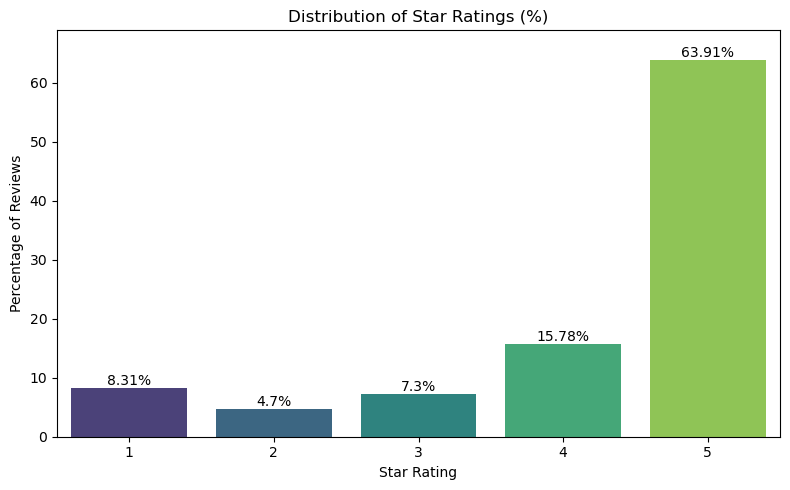

In [ ]:
# Star Rating: Plot 1 -  Bar Graph of Distribution of Star Rating by Percentage

import matplotlib.pyplot as plt
import seaborn as sns

# Convert starcounter to pandas DataFrame
starcounter_pd = starcounter.toPandas()


plt.figure(figsize=(8, 5))
sns.barplot(data=starcounter_pd, x="star_rating", y="Percentage", palette="viridis")

#Titles
plt.title("Distribution of Star Ratings (%)")
plt.xlabel("Star Rating")
plt.ylabel("Percentage of Reviews")
plt.ylim(0, starcounter_pd["Percentage"].max() + 5)

# Show values on top of bars
for i, row in starcounter_pd.iterrows():
    plt.text(i, row["Percentage"] + 0.5, f"{row['Percentage']}%", ha='center')

plt.tight_layout()
plt.show()

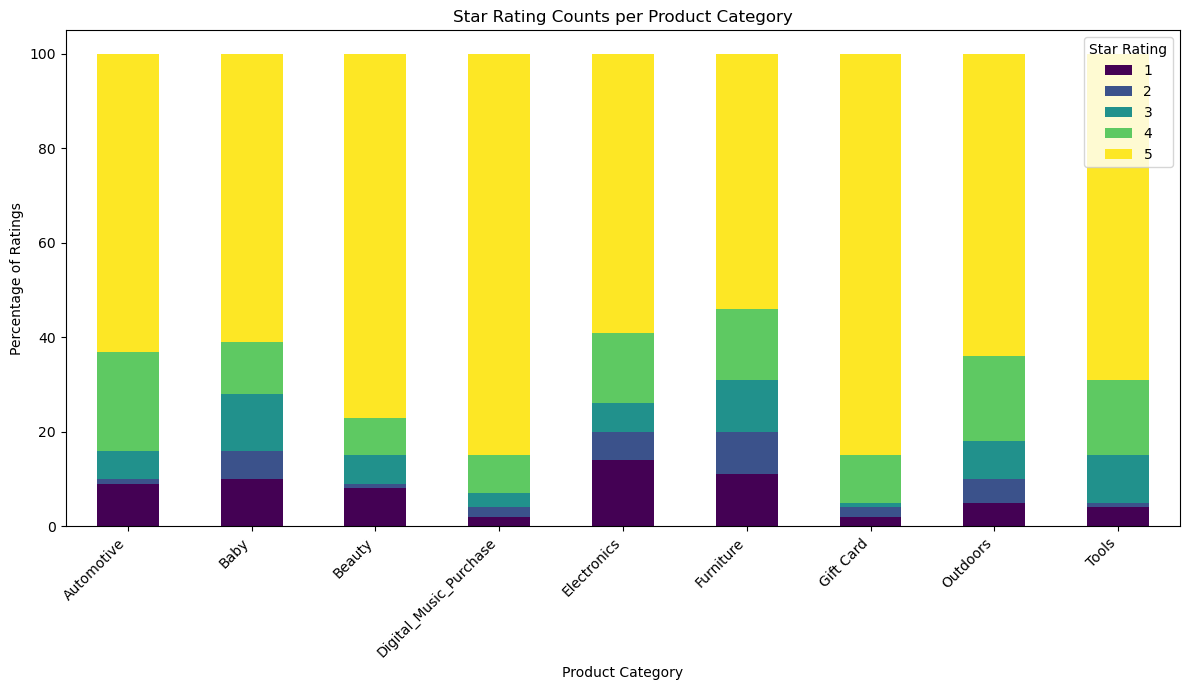

In [ ]:
#Star Rating: Plot 2 - Stacked Bar Chart Star Rating Counts Per Product Category

# #Perform random sampling of 100 rows per category
sampled_data = stardist.groupby('product_category').applyInPandas(
lambda pdf: pdf.sample(n=100, random_state=42), schema=stardist.schema
)

#Convert to Pandas df for visualization
sampled_data_pd = sampled_data.toPandas()


# Group by product category and star rating, then count
rating_counts = sampled_data_pd.groupby(['product_category', 'star_rating']).size().reset_index(name='count')

# Pivot the data for stacked bar chart
pivot_ratings = rating_counts.pivot(index='product_category', columns='star_rating', values='count').fillna(0)

# Plot the stacked bar chart
pivot_ratings.plot(kind='bar', stacked=True, figsize=(12, 7), cmap='viridis')
plt.title("Star Rating Counts per Product Category")
plt.xlabel("Product Category")
plt.ylabel("Percentage of Ratings")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Star Rating")
plt.tight_layout()
plt.show()

In [ ]:
# Total number of Vine vs. Non-Vine reviews (proportion)
vine_counts = df_combined_cleaned.groupBy('vine').count().withColumnRenamed('count', 'total_reviews')
vine_counts.show()

from pyspark.sql import functions as F

# Get the count of Vine reviews
vine_reviews = vine_counts.filter(F.col('vine') == 'Y').select('total_reviews').first()[0]

# Get the count of Non-Vine reviews
non_vine_reviews = vine_counts.filter(F.col('vine') == 'N').select('total_reviews').first()[0]

# Calculate the total number of reviews
total_reviews = vine_reviews + non_vine_reviews

# Calculate the percentage of Vine reviews
percentage_vine = (vine_reviews / total_reviews) * 100

# Display the result
print(f"Percentage of Vine reviews: {percentage_vine:.2f}%")

# You can also create a small DataFrame to display this nicely
from pyspark.sql.types import StructType, StructField, StringType, FloatType

schema = StructType([
    StructField("Review Type", StringType(), False),
    StructField("Percentage", FloatType(), False)
])

data = [("Vine", percentage_vine)]

percentage_df = spark.createDataFrame(data, schema)
percentage_df.show()

+----+-------------+
|vine|total_reviews|
+----+-------------+
|   Y|        83516|
|   N|     20064468|
+----+-------------+

Percentage of Vine reviews: 0.41%
+-----------+----------+
|Review Type|Percentage|
+-----------+----------+
|       Vine|0.41451293|
+-----------+----------+



+----+-----------+-----+
|vine|star_rating|count|
+----+-----------+-----+
|   N|          1|   74|
|   N|          2|   53|
|   N|          3|   79|
|   N|          4|  151|
|   N|          5|  634|
|   Y|          1|   15|
|   Y|          2|   50|
|   Y|          3|  142|
|   Y|          4|  368|
|   Y|          5|  451|
+----+-----------+-----+



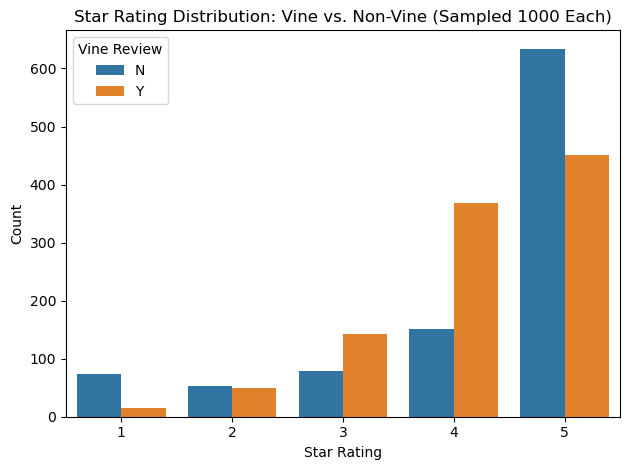

In [ ]:
#Star Rating: Plot 3 - Star Rating Distribution: Vine vs. Non-Vine (Sampled 1000 Each)
import random

# Separate Vine and Non-Vine reviews
vine_reviews = df_combined_cleaned.filter(col('vine') == 'Y')
nonvine_reviews = df_combined_cleaned.filter(col('vine') == 'N')

#Sample 1000 from each
vine_sample = vine_reviews.sample(False, 1000 / vine_reviews.count(), seed=42)
nonvine_sample = nonvine_reviews.sample(False, 1000 / nonvine_reviews.count(), seed=42)

# Union both samples
balanced_sample = vine_sample.union(nonvine_sample)

#Create Vine vs. Not Vine Star Rating Distribution
vinestardist = balanced_sample.groupBy('vine', 'star_rating').count().orderBy('vine', 'star_rating')
vinestardist.show()

# Convert grouped result to Pandas
vinestardist_pd = vinestardist.toPandas()

# Make sure 'star_rating' is categorical
vinestardist_pd['star_rating'] = vinestardist_pd['star_rating'].astype(str)

# Plot using seaborn
sns.barplot(data=vinestardist_pd, x='star_rating', y='count', hue='vine')
plt.title('Star Rating Distribution: Vine vs. Non-Vine (Sampled 1000 Each)')
plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.legend(title='Vine Review')
plt.tight_layout()
plt.show()

Review Length


In [ ]:
#Aggregated
Reviewlengthagg = df_combined_cleaned.withColumn('review_length', length(col('review_body')))
Reviewlengthagg = Reviewlengthagg.groupBy('product_category').agg(avg('review_length').alias('Average Review Length'))
Reviewlengthagg.show()

#Most Likely a scatterplot reviewlength, it is aggregated by product column
ReviewLength = spark.read.parquet('random_rows.parquet')
ReviewLength = ReviewLength.withColumn('review_length', length(col('review_body')))
ReviewLength = ReviewLength.select('product_category', 'review_length')
ReviewLength.show()

#Vine vs Not Vine Review Length Distributions
vinelendist = df_combined_cleaned.withColumn('review_length', length(col('review_body')))
vinelendist = vinelendist.groupBy('vine').agg(round(avg('review_length'),2).alias('Average Review Length Characters'))
vinelendist.show()


+--------------------+---------------------+
|    product_category|Average Review Length|
+--------------------+---------------------+
|                Baby|    342.4862180555112|
|               Tools|    288.1077316490654|
|            Outdoors|    300.9593901242912|
|         Electronics|    375.2726925095938|
|          Automotive|    215.5519498037305|
|           Furniture|    299.2944135580722|
|Digital_Music_Pur...|   234.04863538326882|
|           Gift Card|   127.75676817815938|
|              Beauty|    253.1258069567941|
+--------------------+---------------------+

+----------------+-------------+
|product_category|review_length|
+----------------+-------------+
|     Electronics|         1102|
|     Electronics|           37|
|     Electronics|           13|
|     Electronics|          174|
|     Electronics|           19|
|     Electronics|          178|
|     Electronics|          436|
|     Electronics|          326|
|     Electronics|           85|
|     Electronics|

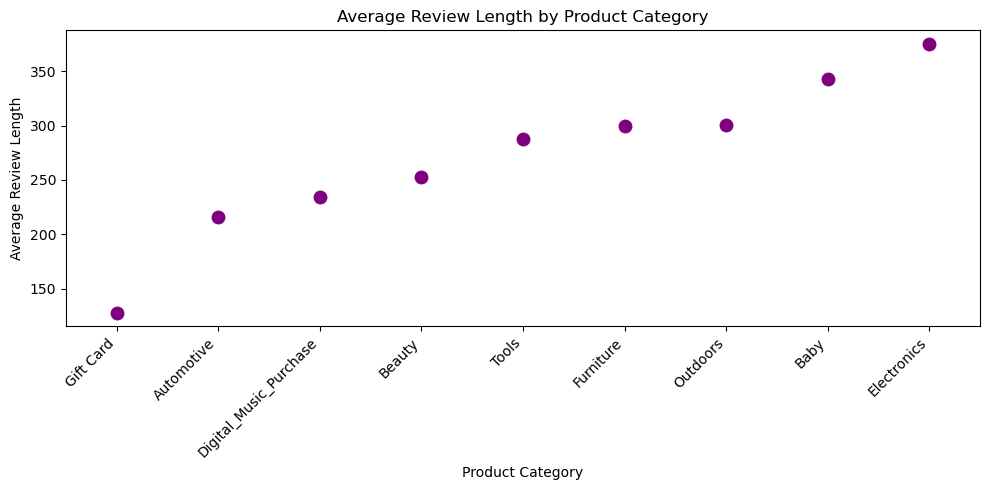

In [ ]:
#Review Length: Plot 1 - Dot Plot of Average Review Length by Product Category

#Convert to Pandas
reviewlength_pd = Reviewlengthagg.toPandas()

# Sort by value for aesthetics
reviewlength_pd.sort_values('Average Review Length', inplace=True)

#Dot Plot
plt.figure(figsize=(10, 5))
sns.stripplot(
    data=reviewlength_pd,
    x='product_category',
    y='Average Review Length',
    size=10,
    color='purple'
)
plt.title('Average Review Length by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Average Review Length')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

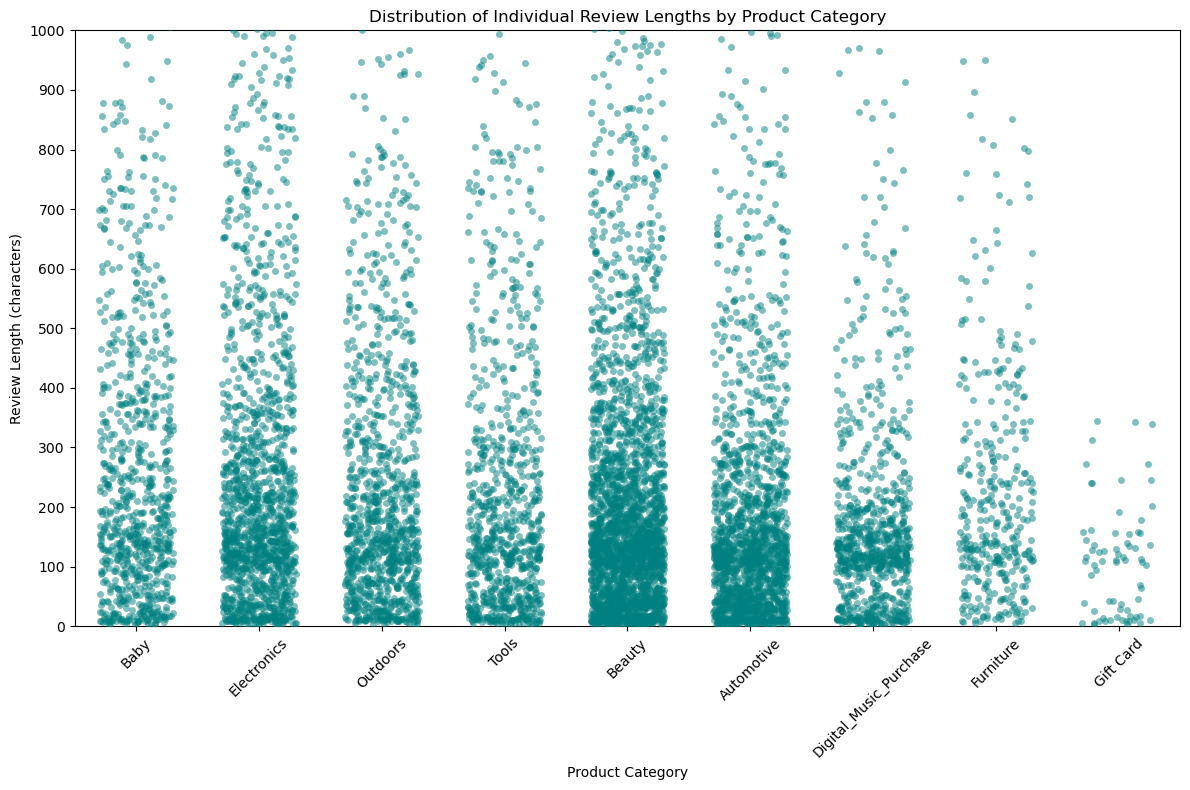

In [ ]:
# Review Length: Plot 2 - Distribution of Review Lengths by Product Category

from pyspark.sql.functions import rand

# Sample 10,000 rows and collect to pandas
filtered_data = (
    df_combined_cleaned
    .select("product_category", "review_body")
    .orderBy(rand())
    .limit(10000)
    .toPandas()
)

filtered_data["review_length"] = filtered_data["review_body"].apply(lambda x: len(x) if x else 0)


plt.figure(figsize=(12, 8))
sns.stripplot(
    data=filtered_data,
    x='product_category',
    y='review_length',
    jitter=0.3,
    alpha=0.5,
    color='teal'
)

plt.ylim(0, 1000)
plt.yticks(range(0, 1001, 100))
plt.xticks(rotation=45)
plt.title('Distribution of Individual Review Lengths by Product Category')
plt.ylabel('Review Length (characters)')
plt.xlabel('Product Category')
plt.tight_layout()
plt.show()

Helpfulness Score

In [ ]:
#Most Likely a scatterplot helpfulness score, it is aggregated by product column
helpfulvote = spark.read.parquet('random_rows.parquet')
helpfulvote = helpfulvote.select('product_category', 'helpful_votes')
helpfulvote = helpfulvote.groupBy('product_category').agg(avg('helpful_votes').alias('Average # of Helpful Votes'))
helpfulvote.show()

#Vine vs Not Vine Helpful Vote Distributions
vinehlpful = df_combined_cleaned.groupBy('vine').agg(round(avg('helpful_votes'),2).alias('Average # of Helpful Votes'))
vinehlpful.show()

+--------------------+--------------------------+
|    product_category|Average # of Helpful Votes|
+--------------------+--------------------------+
|         Electronics|                       1.6|
|            Outdoors|                      1.09|
|               Tools|                      1.05|
|                Baby|                      0.73|
|           Furniture|                      1.38|
|              Beauty|                       0.9|
|          Automotive|                      0.51|
|Digital_Music_Pur...|                      0.22|
|           Gift Card|                      0.06|
+--------------------+--------------------------+

+----+--------------------------+
|vine|Average # of Helpful Votes|
+----+--------------------------+
|   Y|                      3.47|
|   N|                      1.54|
+----+--------------------------+



/scratch/mtakeuchi1/job_39794652/ipykernel_3212160/3499139838.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=helpfulvote_pd,


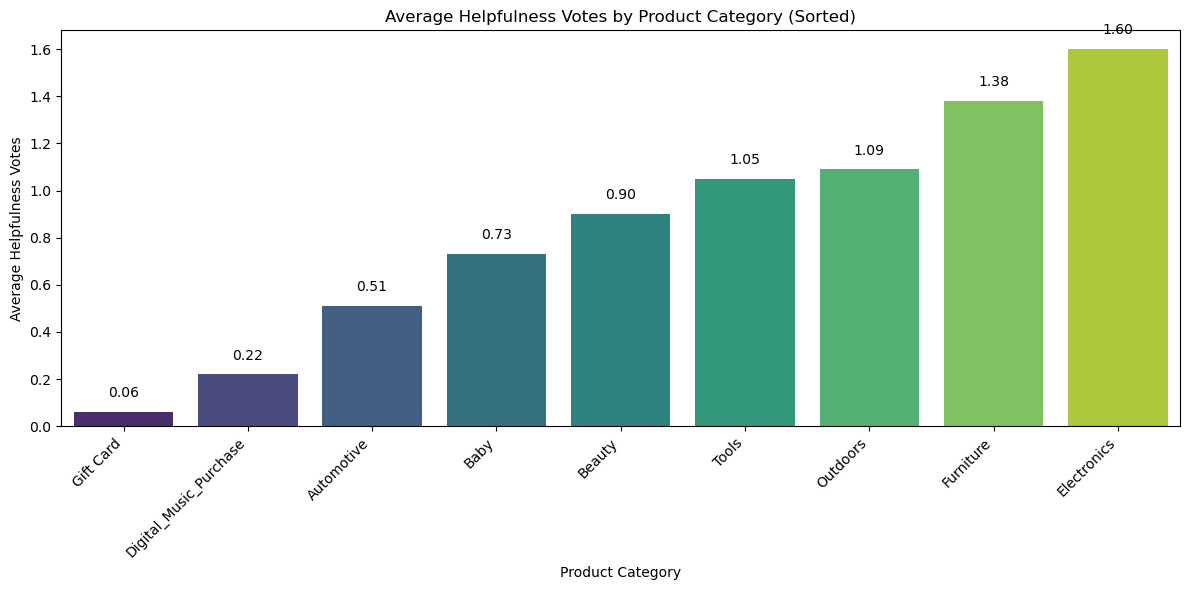

In [ ]:
# Helpfulness Score: Plot 1 - Bar Chart: Average Helpfulness Votes by Product Category

import matplotlib.pyplot as plt
import seaborn as sns

helpfulvote_pd = helpfulvote.toPandas()
helpfulvote_pd = helpfulvote_pd.sort_values('Average # of Helpful Votes', ascending=True)

# Plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=helpfulvote_pd,
                 x='product_category',
                 y='Average # of Helpful Votes',
                 palette='viridis',
                 errorbar=None)

for i, (_, row) in enumerate(helpfulvote_pd.iterrows()):
    ax.text(i, row['Average # of Helpful Votes'] + 0.05,
            f"{row['Average # of Helpful Votes']:.2f}",
            ha='center', va='bottom', fontsize=10)

plt.title("Average Helpfulness Votes by Product Category (Sorted)")
plt.xlabel("Product Category")
plt.ylabel("Average Helpfulness Votes")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

/scratch/mtakeuchi1/job_39794652/ipykernel_3212160/1620827161.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=vinehlpful_pd, x='vine', y='Average # of Helpful Votes', palette='magma')


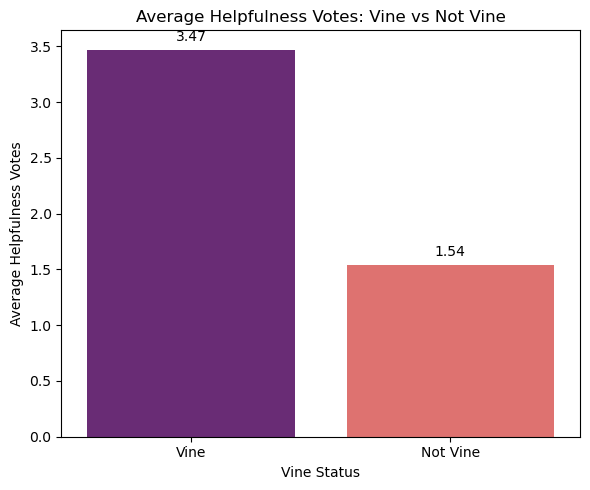

In [ ]:
# Helpfulness Score: Plot 2 - Box Plot: Distribution of Helpfulness Votes by Vine vs Non-Vine
vinehlpful_pd = vinehlpful.toPandas()

# Rename Vine column
vinehlpful_pd['vine'] = vinehlpful_pd['vine'].replace({'Y': 'Vine', 'N': 'Not Vine'})

# Plot
plt.figure(figsize=(6, 5))
sns.barplot(data=vinehlpful_pd, x='vine', y='Average # of Helpful Votes', palette='magma')

for index, row in vinehlpful_pd.iterrows():
    plt.text(index, row['Average # of Helpful Votes'] + 0.05, f"{row['Average # of Helpful Votes']:.2f}",
             ha='center', va='bottom')

plt.title('Average Helpfulness Votes: Vine vs Not Vine')
plt.xlabel('Vine Status')
plt.ylabel('Average Helpfulness Votes')
plt.tight_layout()
plt.show()


Sentiment Analysis

In [ ]:
#Basic sentiment Analyzer
from textblob import TextBlob
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
df_random_rows_sentiment = df_combined_cleaned.withColumn('row_num', row_number().over(Window.partitionBy('vine').orderBy(rand()))).filter(col('row_num') <= 1000)

def get_sentiment(text):
    if text:
        return TextBlob(text).sentiment.polarity
    return 0.0

sentiment_udf = udf(get_sentiment, FloatType())



In [ ]:
#Sentiment Analysis Vine vs Not vine top 10000 Random, scatterplot would be good, or can aggregate for barplot
df_random_rows_sentiment2 = df_random_rows_sentiment.withColumn('sentiment', sentiment_udf(col('review_body')))
df_random_rows_sentiment2 = df_random_rows_sentiment2.select('vine', 'sentiment')
df_random_rows_sentiment2.show()

+----+------------+
|vine|   sentiment|
+----+------------+
|   Y|  0.18333334|
|   Y|   0.3025641|
|   Y| 0.089423075|
|   Y|  0.21904762|
|   Y|  0.12115385|
|   Y|  0.36190477|
|   Y|  0.35645407|
|   Y|  0.31610963|
|   Y|  0.17757086|
|   Y|  0.14412458|
|   Y|   0.1367347|
|   Y|  0.16078947|
|   Y|        0.04|
|   Y|0.0073848236|
|   Y|  0.21960784|
|   Y|  0.24412037|
|   Y|  0.28166667|
|   Y|  0.15637626|
|   Y|-0.007575758|
|   Y|  0.14664502|
+----+------------+
only showing top 20 rows



In [ ]:
#Average Sentiment Across PRoduct Categories Top 10000 Random, scattterplot would be good, or can aggregate for barplot
sentiment_categories = df_random_rows_sentiment.withColumn('sentiment', sentiment_udf(col('review_body')))
sentiment_categories = sentiment_categories.select('product_category', 'sentiment')
sentiment_categories.show()

+----------------+------------+
|product_category|   sentiment|
+----------------+------------+
|          Beauty|  0.18333334|
|     Electronics|   0.3025641|
|          Beauty| 0.089423075|
|          Beauty|  0.21904762|
|      Automotive|  0.12115385|
|          Beauty|  0.36190477|
|     Electronics|  0.35645407|
|     Electronics|  0.31610963|
|          Beauty|  0.17757086|
|     Electronics|  0.14412458|
|        Outdoors|   0.1367347|
|          Beauty|  0.16078947|
|          Beauty|        0.04|
|     Electronics|0.0073848236|
|            Baby|  0.21960784|
|        Outdoors|  0.24412037|
|     Electronics|  0.28166667|
|          Beauty|  0.15637626|
|           Tools|-0.007575758|
|     Electronics|  0.14664502|
+----------------+------------+
only showing top 20 rows



/scratch/mtakeuchi1/job_39794652/ipykernel_3212160/1223939055.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sentiment_pd, x='product_category', y='sentiment', palette='coolwarm', errorbar=None)


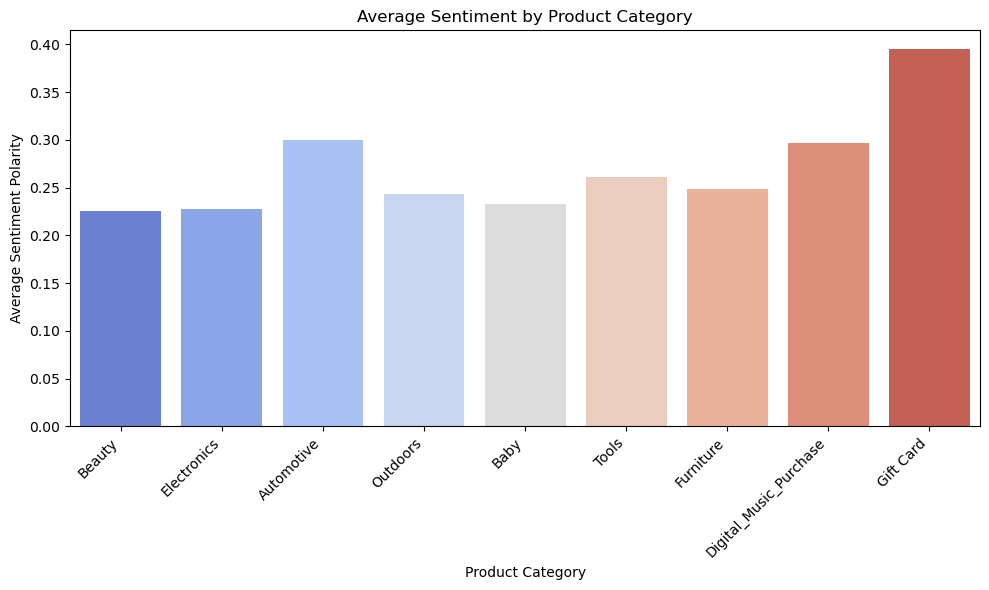

In [ ]:
# Sentiment Analysis: Plot 1 - Bar Plot: Average Sentiment by Product Category
sentiment_pd = sentiment_categories.toPandas()

#plot
plt.figure(figsize=(10, 6))
sns.barplot(data=sentiment_pd, x='product_category', y='sentiment', palette='coolwarm', errorbar=None)
plt.xticks(rotation=45, ha='right')

plt.title('Average Sentiment by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Average Sentiment Polarity')
plt.tight_layout()
plt.show()


/scratch/mtakeuchi1/job_39794652/ipykernel_3212160/1969312864.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=sample_sentiment, x="vine", y="sentiment", palette="Set1", showfliers=False)


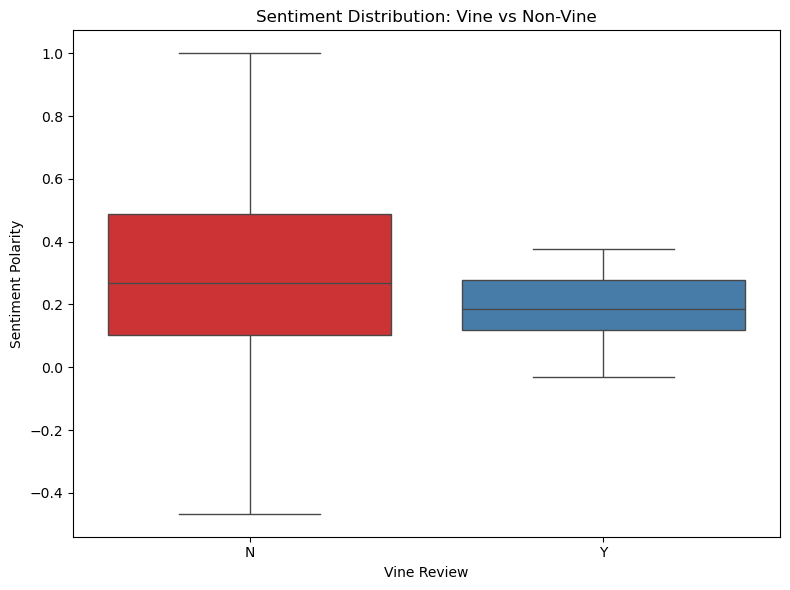

In [ ]:
# Sentiment Analysis: Plot 2 - Box Plot: Sentiment Polarity by Vine Status

from textblob import TextBlob
from pyspark.sql.functions import rand

# Sample rows and convert to Pandas
df_random_rows_sentiment = (
    df_combined_cleaned
    .select("vine", "review_body")  # only select available columns
    .orderBy(rand())
    .limit(10000)
)

sample_sentiment = df_random_rows_sentiment.toPandas()

# Compute sentiment using TextBlob
sample_sentiment["sentiment"] = sample_sentiment["review_body"].apply(
    lambda x: TextBlob(x).sentiment.polarity if x else None
)

# Add review length
sample_sentiment["review_length"] = sample_sentiment["review_body"].apply(lambda x: len(x) if x else 0)

#plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=sample_sentiment, x="vine", y="sentiment", palette="Set1", showfliers=False)
plt.title("Sentiment Distribution: Vine vs Non-Vine")
plt.xlabel("Vine Review")
plt.ylabel("Sentiment Polarity")
plt.tight_layout()
plt.show()

Review Verification Status

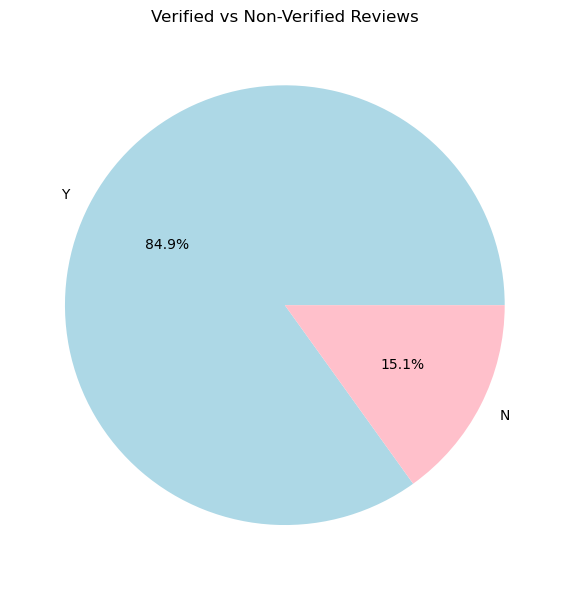

In [ ]:
# Review Verification Status: Plot 1 - Pie Chart: Verified vs Non-Verified Reviews
verified_df = df_combined_cleaned.groupBy("verified_purchase").count().toPandas()

#plot
plt.figure(figsize=(6, 6))
plt.pie(verified_df['count'], labels=verified_df['verified_purchase'], autopct='%1.1f%%', colors=['lightblue','pink'])
plt.title('Verified vs Non-Verified Reviews')
plt.tight_layout()
plt.show()

/scratch/mtakeuchi1/job_39794652/ipykernel_3212160/3848894602.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=verified_by_category, x="product_category", y="Verified Percentage", palette="crest")


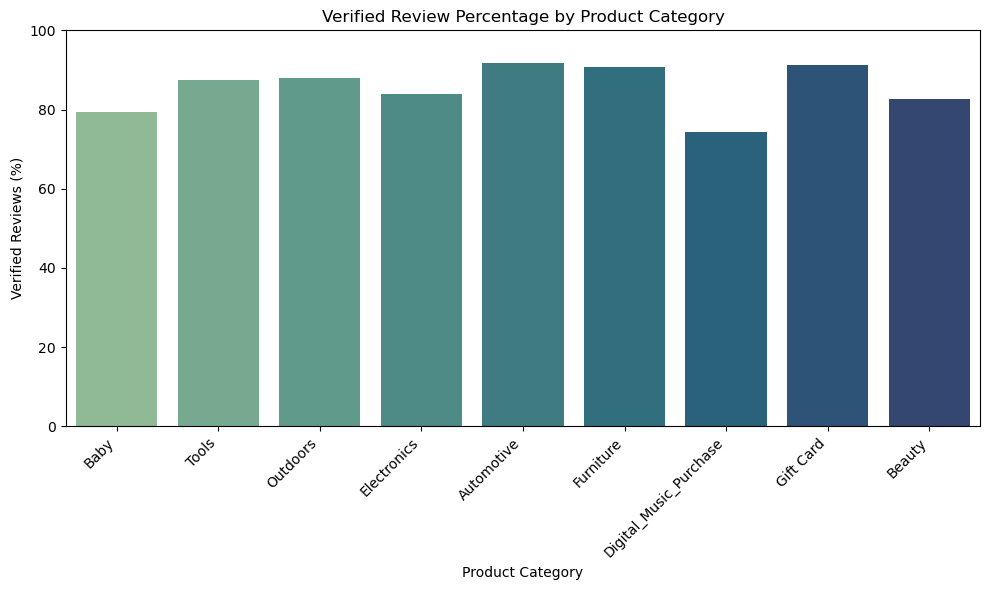

In [ ]:
# Review Verification Status: Plot 2 - Bar Plot: Verified Review Percentage by Category
from pyspark.sql import functions as F

verified_by_category = df_combined_cleaned.groupBy("product_category").agg(
    (F.sum(F.when(F.col("verified_purchase") == "Y", 1).otherwise(0)) / F.count("*") * 100).alias("Verified Percentage")
).toPandas()

#plot
plt.figure(figsize=(10, 6))
sns.barplot(data=verified_by_category, x="product_category", y="Verified Percentage", palette="crest")
plt.xticks(rotation=45, ha='right')
plt.title("Verified Review Percentage by Product Category")
plt.xlabel("Product Category")
plt.ylabel("Verified Reviews (%)")
plt.ylim(0, 100)
plt.tight_layout()
plt.show()


#ML Model 1 (Logistic Regression)

In [ ]:
from pyspark.sql.functions import col, length, when
from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    Tokenizer, StopWordsRemover, HashingTF, IDF,
    VectorAssembler, StandardScaler, StringIndexer
)
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [ ]:
#Load and Clean Data
df = spark.read.parquet("combined_cleaned_amazon_reviews.parquet")

df_cleaned = df_combined_cleaned.filter(col("review_body").isNotNull()) \
               .withColumn("review_body", col("review_body").cast("string")) \
               .withColumn("star_rating", col("star_rating").cast("int")) \
               .withColumn("review_length", length(col("review_body"))) \
               .withColumn("vine_binary", when(col("vine") == "Y", 1).otherwise(0))

In [ ]:
df_sampled = df_cleaned.sample(withReplacement=False, fraction=0.05, seed=42)  # 5% sample


In [ ]:
#Pipeline for Logistic Regression
tokenizer = Tokenizer(inputCol="review_body", outputCol="words")
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
hashingTF = HashingTF(inputCol="filtered_words", outputCol="rawFeatures", numFeatures=2000)  # smaller feature space
idf = IDF(inputCol="rawFeatures", outputCol="features")

numeric_assembler = VectorAssembler(inputCols=["review_length"], outputCol="numeric_features")

scaler = StandardScaler(inputCol="numeric_features", outputCol="scaled_numeric_features", withMean=True, withStd=True)

#Combine features (without scaling)
full_feature_assembler = VectorAssembler(inputCols=["numeric_features", "features"], outputCol="final_features")

indexer = StringIndexer(inputCol="star_rating", outputCol="label")

lr_classifier = LogisticRegression(labelCol="label", featuresCol="final_features", maxIter=100)

pipeline = Pipeline(stages=[
    tokenizer,
    stopwords_remover,
    hashingTF,
    idf,
    indexer,
    numeric_assembler,
    scaler,
    full_feature_assembler,
    lr_classifier
])


In [ ]:
#Train and Evaluate
train_data, test_data = df_sampled.randomSplit([0.8, 0.2], seed=42)
lr_model = pipeline.fit(train_data)
lr_predictions = lr_model.transform(test_data)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

accuracy = evaluator.evaluate(lr_predictions)
f1_score = f1_evaluator.evaluate(lr_predictions)

print(f"Logistic Regression Accuracy: {accuracy:.4f}")
print(f"Logistic Regression F1 Score: {f1_score:.4f}")


Logistic Regression Accuracy: 0.6740
Logistic Regression F1 Score: 0.5983


#Model Evaluation


In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics
import numpy as np

#Convert predictions to RDD with (prediction, label) format
lr_prediction_and_labels = lr_predictions.select("prediction", "label") \
    .rdd.map(lambda row: (float(row.prediction), float(row.label)))

#Initialize metrics
metrics = MulticlassMetrics(lr_prediction_and_labels)

#Get confusion matrix
confusion_matrix = metrics.confusionMatrix().toArray()

print("Logistic Regression Confusion Matrix:\n", confusion_matrix)


Logistic Regression Confusion Matrix:
 [[124673.   2289.   1611.    637.    276.]
 [ 26791.   3393.    790.    914.    223.]
 [  9108.    232.   6671.    328.    316.]
 [ 10597.   1239.   1282.   1177.    308.]
 [  5994.    433.   2000.    551.    388.]]


#Conclusion

With an F1 of 0.5983, the logistic regression model demonstrates moderate performance, with room for improvement. To improve the model we will increase the sample size from 5% to 20% of the data in order to better assess model performance on a larger subset of the data, using access to the SDSC. Increasing 4x the original sample should capture the vocabulary distribution while remaining computationally manageable.

Additionally, we will increase the numFeatures size incrementally to examine its effect on model performance (F1 and accuracy). A larger feature space may help reduce collisions and better capture word-level nuances.

Currently, the model is underfitting in the fitting graph. This is likely due to the smaller train sample size and using tf-idf rather than richer vectorizing words, which would help with context. We originally used a smaller sample size due to resource/memory constraints, but there is a clear detrimental tradeoff on accuracy of the model.

As an alternative model, we will use a random forest classifier due to its ability to handle non-linear relationships, provide feature importance insights and perform robustly even in the presence of hash collisions or moisy features, which may improve performance over logistic regression. We anticipate that Random Forest may outperform Logistic Regression by better handling complex word patterns and uncovering deeper relationships in the data.